# Прогноз количества заказов такси

**Описание проекта:** Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Цель проекта:** Постройте модель для предсказания количества заказов такси.

**Задача:** Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### План проекта

<br>[1. Загрузка и подготовка данных](#step1)
<br>[1.1 Вывод к этапу 1](#step2)
<br>[2. Анализ данных](#step3)
<br>[2.1 Вывод к этапу 2](#step4)
<br>[3. Обучение моделей](#step5)
<br>[3.1 Вывод к этапу 3](#step6)
<br>[4. Тестирование моделей](#step7)
<br>[5.Общий вывод](#step8)

# 1. Загрузка и подготовка данных<a id='step1'></a>

In [402]:
#Прежде всего импортирую нужные на этом этапе библиотеки
import pandas as pd #Импортирую библиотеку pandas
%matplotlib inline
import matplotlib.pyplot as plt #Импортирую библиотеку matplotlib
import seaborn as sns #Импортирую библиотеку seaborn
import numpy as np #Импортирую библиотеку высокоуровневых математических функций numpy

In [403]:
#Читаю файл с данными
data = pd.read_csv('/datasets/taxi.csv')
#Печатаю первые 10 строк таблицы для ознакомления с данными
display(data.head(10))
#Получаю информацию о датасете
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [404]:
#Заново читаю файл с данными, задав параметры index_col, parse_dates, для определения datetime в столбце
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) 
#Сортирую датасет по индексам
data.sort_index(inplace=True)
#Провожу ресемплирование на промежуток времени 1 час
data = data.resample('1H').sum()
#Печатаю первые 10 строк таблицы для ознакомления с данными
display(data.head(10))
#Получаю информацию о датасете
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


## 1.1 Вывод к этапу 1 <a id='step2'></a>

На первом этапе произведена загрузка данных и их подготовка для обучения моделей.
<br>Для анализа данных и построения модели предоставлен датасет, содержащий собрала исторические данные о заказах такси в аэропортах сервиса компании «Чётенькое такси». 

<br>**Исходный датасет состоит из следующих столбцов:**
<br>• datetime — дата и время заказа такси
<br>• num_orders — количество заказов такси (целевой признак)
<br>Количество строк в датасете 4416. Пропуски в данных отсутствуют.

<br>Для подготовки данных к функции *pd.read_csv* были применены парамтры *index_col* и *parse_dates* для определения данных типа datetime и назначением этого столбца в качестве индексов. Дополнительно выполнено ресемплирование на промежуток времени 1 час.

# 2. Анализ данных<a id='step3'></a>

Перед обучением моделей проведем анализ имеющихся данных.

In [405]:
print(data.index.min())
print(data.index.max())
print(data.index.max() - data.index.min())
print()
print(data['num_orders'].min())
print(data['num_orders'].max())

2018-03-01 00:00:00
2018-08-31 23:00:00
183 days 23:00:00

0
462


Данные собраны за 183 дня и 23 часа. Минимальное количество заказов за 1 час: 0; максимальное: 462 

Теперь проведем анализ временного ряда.

In [406]:
from statsmodels.tsa.seasonal import seasonal_decompose

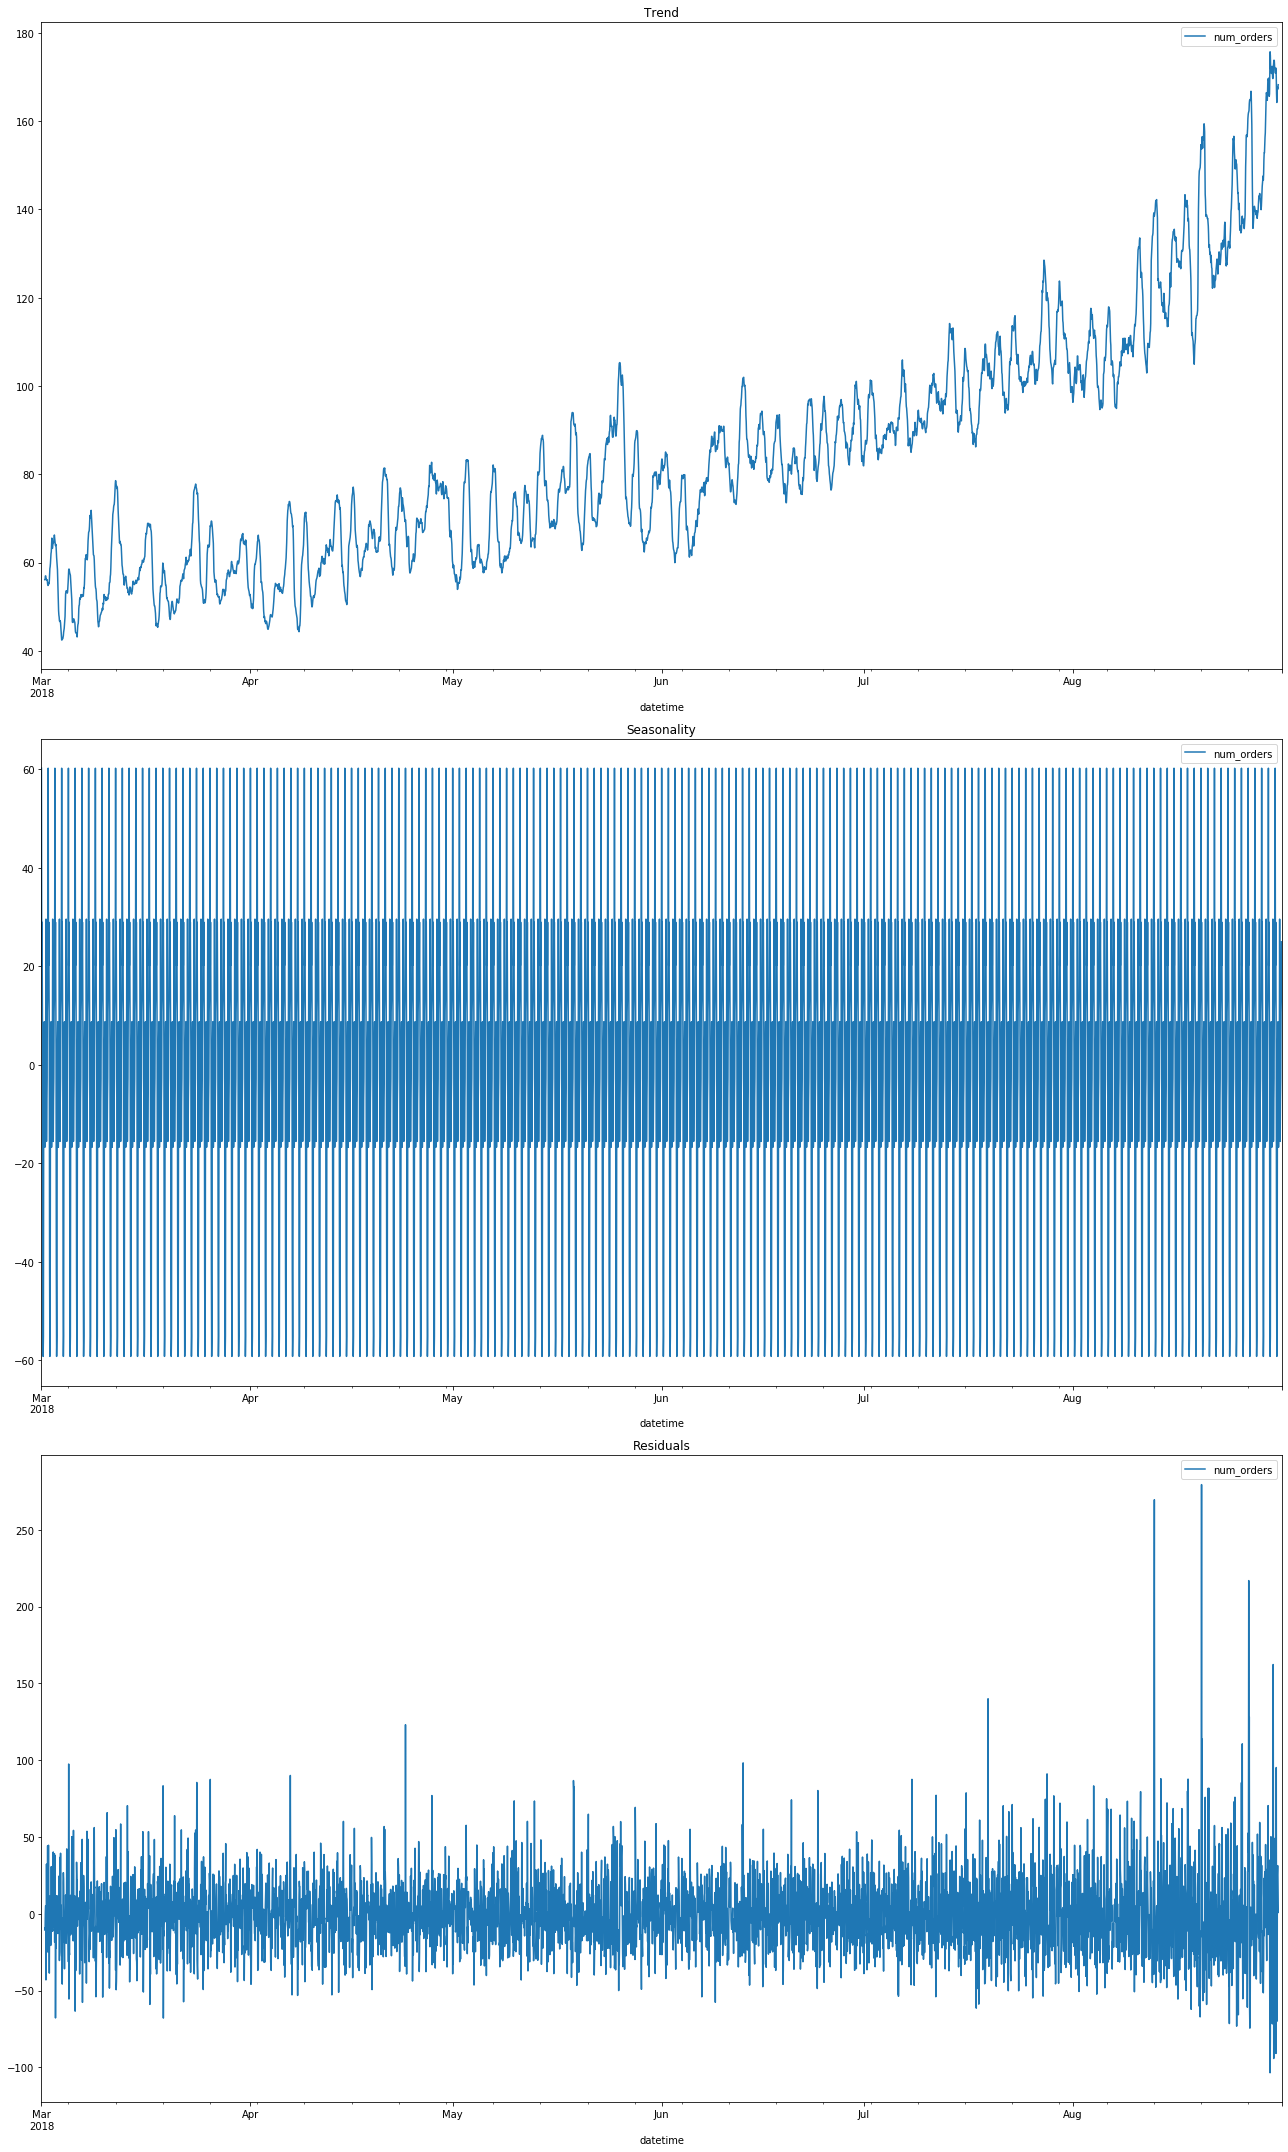

In [413]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(18, 30))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Анализ графика всего временного ряда несколько затруднен, поскольку имеет место суточная сезонность. Хотя трнед на всем ряде явно отражает постепенное увеличение заказов "Чётенького такси", вероятно маркетинговая кампания компании удачно привлекает новых "чётеньких" клиентов.

Рассмотрим графики на более коротком отрезке, длинной в 1 месяц.

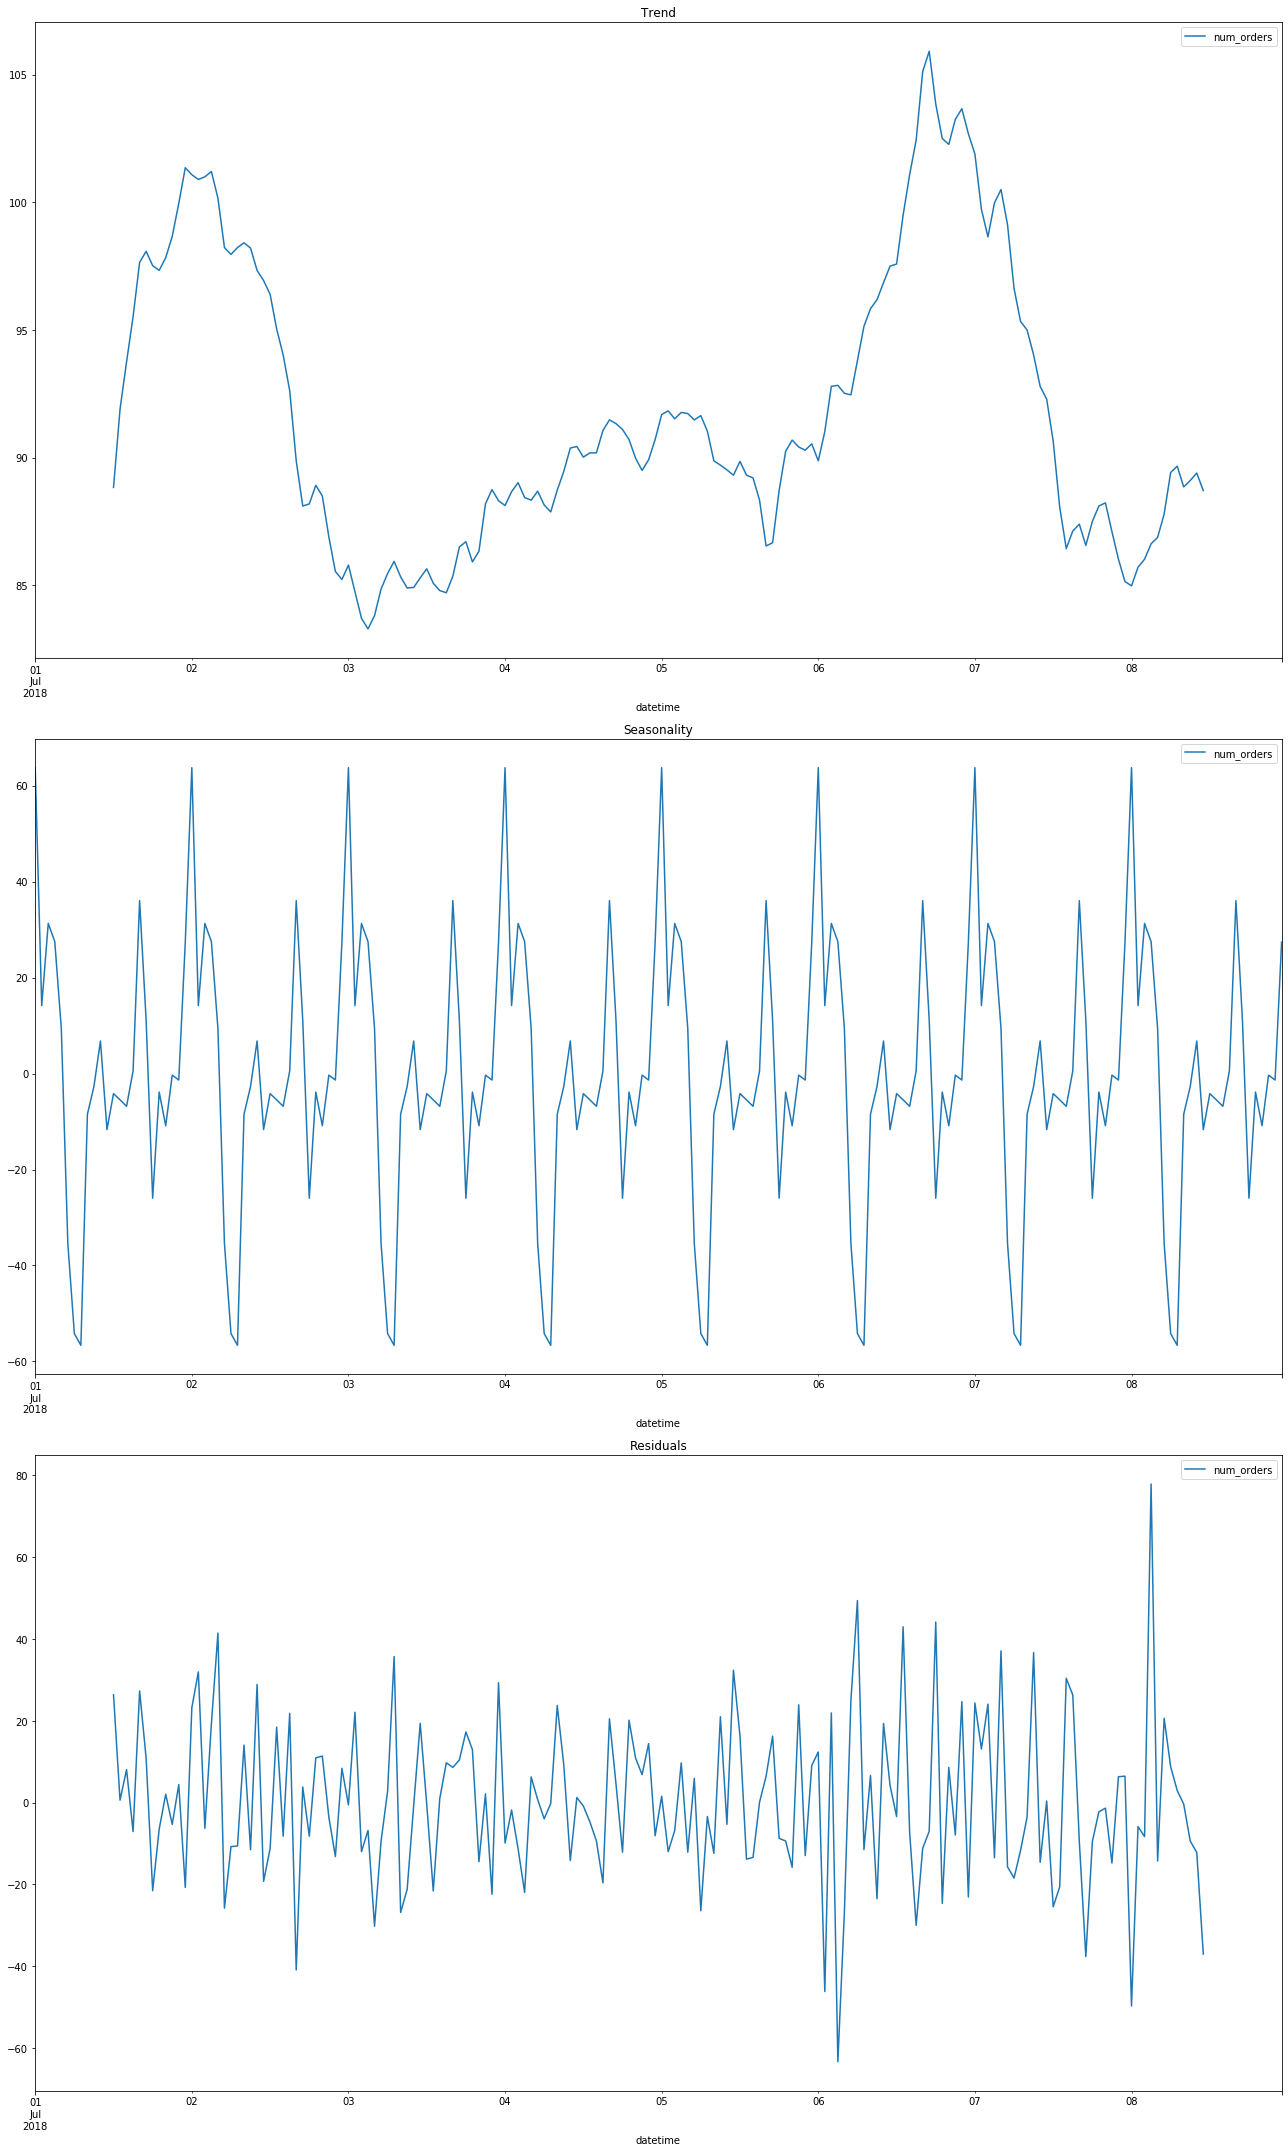

In [412]:
data_cut = data['2018-07-01':'2018-07-08']

decomposed_cut = seasonal_decompose(data_cut)

plt.figure(figsize=(18, 30))
plt.subplot(311)
decomposed_cut.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_cut.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_cut.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Так-то лучше, теперь явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

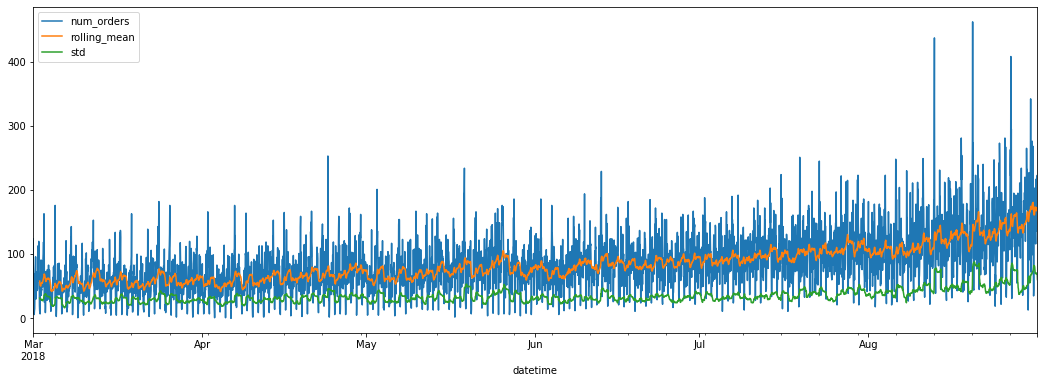

In [369]:
data_plot = data.copy()
data_plot['rolling_mean'] = data_plot.rolling(30).mean()
data_plot['std'] = data_plot['num_orders'].rolling(30).std()
data_plot.plot(figsize=(18, 6))

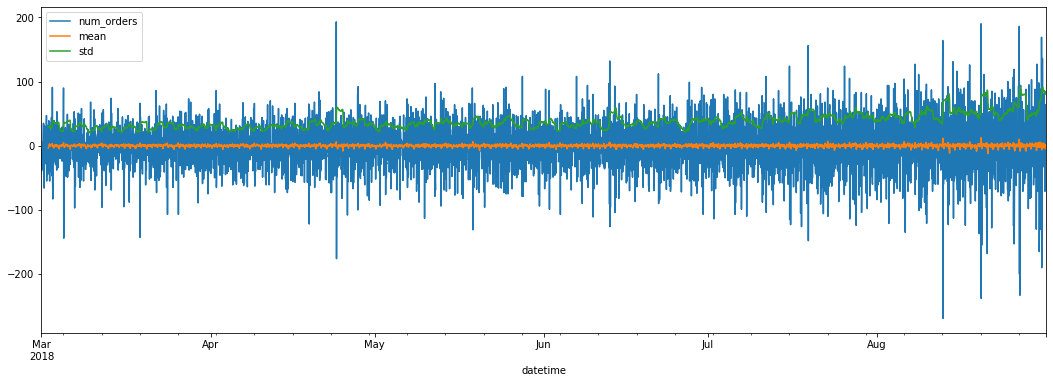

In [370]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(30).mean()
data_shift['std'] = data_shift['num_orders'].rolling(30).std()
data_shift.plot(figsize=(18, 6))

## 2.1 Вывод к этапу 2 <a id='step4'></a>

На этом этапе проведен анализ данных. Методом декомпозиции были выделены следующие аспекты:
1. За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.
2. На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

# 3. Обучение моделей <a id='step5'></a>

Обучим четыре модели ориентируясь на метрику RMSE. В качестве моделей используем Случайный лес, Линейную регрессию, LGBMRegressor, CatBoostRegressor.

In [371]:
from sklearn.ensemble import RandomForestRegressor #Импортирую модель RandomForestRegressor из библиотеки sklearn
from sklearn.tree import DecisionTreeRegressor #Импортирую модель DecisionTreeRegressor из библиотеки sklearn
from sklearn.linear_model import LinearRegression #Импортирую модель LinearRegression из библиотеки sklearn
from sklearn.model_selection import cross_val_score #Импортирую функцию cross_val_score из библиотеки sklearn
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV #Импортирую функцию TimeSeriesSplit и GridSearchCV 
from sklearn.metrics import make_scorer #Импортирую функцию make_scorer из библиотеки sklearn
from sklearn.model_selection import train_test_split #Импортирую функцию train_test_split из библиотеки sklearn
from sklearn.metrics import mean_squared_error #Импортирую метрику mean_squared_error из библиотеки sklearn
import lightgbm as lgb #Импортирую Light GBM
import catboost as cb #Импортирую CatBoost

In [372]:
#Объявляю функцию для создания признаков, а именно день недели, час "отстающие значения" и скользящее среднее
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [373]:
#Применяю функцию создания признаков
make_features(data, 50, 36)

In [374]:
data = data.dropna() #Удаляю пропуски данных, возникшие в результате работы функции make_features()
#Разделяяю датасет на обучающую и тестовую выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)

#train = train.dropna()

#Выделяю признаки и целевой признак в выборках
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [375]:
#Проверяю результат сплита
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3929, 53)
(437, 53)
(3929,)
(437,)


display(features_train.head(10))
display(features_train.head(10))

In [376]:
#Объявляю функцию для расчета метрики RMSE
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
#С помощию функции make_scorer создаю метрику RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

В связи с тем, что мы работаем с временным рядом, нельзя применять кросс-валидацию в привычном виде для подбора гиперпараметров моделей с помощью GridSearchCV. Поэтому применим функцию TimeSeriesSplit().

In [377]:
%%time
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
#Обучаю модель
regression.fit(features_train, target_train)
#Определяю RMSE модели с помощью кросс-валидации
regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 25.481865724878336
CPU times: user 432 ms, sys: 466 ms, total: 899 ms
Wall time: 842 ms


In [378]:
%%time
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
forest = RandomForestRegressor()
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(5, 40, 5),
                     'max_depth': range(1, 14, 2),
                     'min_samples_leaf': range(1,8),
                     'min_samples_split': range(2,8,2) }

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)
forest_grid.fit(features_train, target_train)

CPU times: user 27min 12s, sys: 1.67 s, total: 27min 13s
Wall time: 27min 48s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe11f6bc050>,
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimator...', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_j

In [379]:
%%time
#Определяю оптимальные гиперпараметры и качество модели на кросс-валидации
forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train) * (-1)
print(forest_params)
print(forest_score)
print('_______________')

{'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 30}
11.298286563113471
_______________
CPU times: user 26.9 ms, sys: 18 µs, total: 26.9 ms
Wall time: 40.5 ms


In [380]:
%%time
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
lg = lgb.LGBMRegressor()
#Определяю словарь с набором параметров
lg_parametrs = {"max_depth": [15, 20, 25],
               "learning_rate" : [0.1, 0.15],
               "num_leaves": range (5, 25, 5),
               "n_estimators": range (5, 40, 5)
             }
#Применяю GridSearchCV с кросс-валидацией
lg_grid = GridSearchCV(lg, lg_parametrs, scoring=RMSE_score, cv=my_cv)
lg_grid.fit(features_train, target_train)

CPU times: user 3min 26s, sys: 1.81 s, total: 3min 27s
Wall time: 3min 30s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe11f6bc9d0>,
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     obje...
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.15],
                         'max_depth': [15, 20, 25],
                    

In [381]:
%%time
#Определяю оптимальные гиперпараметры и качество модели на кросс-валидации
lg_params = lg_grid.best_params_
lg_score = lg_grid.score(features_train, target_train) * (-1)
print(lg_params)
print(lg_score)
print('_______________')

{'learning_rate': 0.15, 'max_depth': 15, 'n_estimators': 35, 'num_leaves': 20}
16.731341360553152
_______________
CPU times: user 73 ms, sys: 7.98 ms, total: 81 ms
Wall time: 86.8 ms


In [382]:
%%time
import catboost as cb #Импортирую CatBoost
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)
#Объявляю модель
cb = cb.CatBoostRegressor()
#Определяю словарь с набором параметров
cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }

#cb_parametrs = {"iterations": [20],
#                "depth": range(2, 14, 2),
#                "learning_rate" : [0.01, 0.1]
#             }
#Применяю GridSearchCV с кросс-валидацией
cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=my_cv)
cb_grid.fit(features_train, target_train)

0:	learn: 28.7017549	total: 49ms	remaining: 48.9s
1:	learn: 28.3328772	total: 51.9ms	remaining: 25.9s
2:	learn: 27.9752476	total: 53.5ms	remaining: 17.8s
3:	learn: 27.6072479	total: 55.2ms	remaining: 13.7s
4:	learn: 27.2733715	total: 56.8ms	remaining: 11.3s
5:	learn: 26.9623461	total: 58.5ms	remaining: 9.68s
6:	learn: 26.6706701	total: 63.5ms	remaining: 9s
7:	learn: 26.3731322	total: 65.5ms	remaining: 8.12s
8:	learn: 26.0949922	total: 67.7ms	remaining: 7.45s
9:	learn: 25.8525489	total: 70.2ms	remaining: 6.95s
10:	learn: 25.5924684	total: 72.2ms	remaining: 6.49s
11:	learn: 25.3202070	total: 74.6ms	remaining: 6.14s
12:	learn: 25.0622445	total: 76.4ms	remaining: 5.8s
13:	learn: 24.7903206	total: 78.8ms	remaining: 5.55s
14:	learn: 24.5694509	total: 81.9ms	remaining: 5.38s
15:	learn: 24.3613768	total: 160ms	remaining: 9.84s
16:	learn: 24.1512300	total: 162ms	remaining: 9.39s
17:	learn: 23.9444686	total: 164ms	remaining: 8.95s
18:	learn: 23.7553164	total: 166ms	remaining: 8.58s
19:	learn: 23

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe11f424050>,
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fe11f321450>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=0)

In [383]:
%%time
#Определяю оптимальные гиперпараметры и качество модели на кросс-валидации
cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train, target_train) * (-1)
print(cb_params)
print(cb_score)
print('_______________')

{'depth': 6, 'learning_rate': 0.03}
13.150719583769032
_______________
CPU times: user 27.2 ms, sys: 4.56 ms, total: 31.8 ms
Wall time: 13.9 ms


## 3.1 Вывод к этапу 3 <a id='step6'></a>

На данном этапе подобраны гипермараметры для каждой модели.

# 4. Тестирование моделей <a id='step7'></a>

Проведем тестирование моделей с подобранными гиперпараметрами.

In [384]:
%%time
#Обучаю модель
regression_model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)

#Определяю метрику RMSE
regression_RMSE = round(RMSE(target_test, regression_model_predictions), 3)
print('RMSE модели Линейной регрессии:', regression_RMSE)

RMSE модели Линейной регрессии: 42.046
CPU times: user 76.2 ms, sys: 59.9 ms, total: 136 ms
Wall time: 119 ms


In [416]:
#Объявляю функцию для построения сравнительных графиков "целевой признак - предсказание модели"
def graphicaizer(predictions):
    model_data = pd.DataFrame({"target":target_test, "predict":predictions})
    model_data.plot(figsize=(18, 6))
    model_data['2018-08-22':'2018-08-24'].plot(figsize=(18, 6))

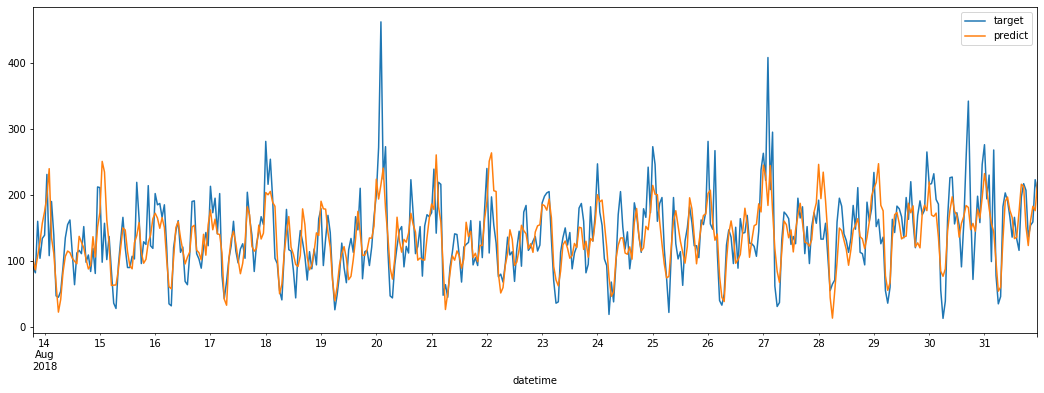

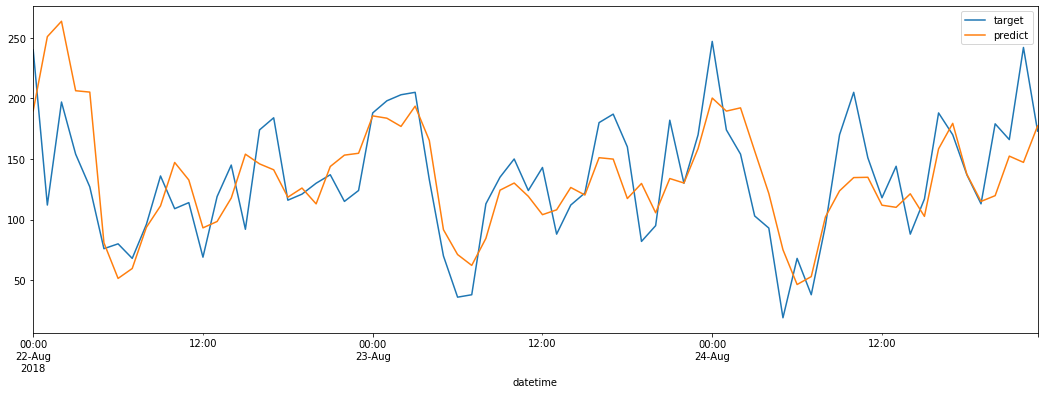

In [417]:
graphicaizer(regression_model_predictions)

In [387]:
%%time
#Обучаю модель на оптимальных гиперпараметрах
forest_model = RandomForestRegressor(random_state=42,
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf = forest_params['min_samples_leaf'],
                                     min_samples_split = forest_params['min_samples_split'],
                                     n_estimators = forest_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)

#Определяю метрику RMSE
forest_RMSE = round(RMSE(target_test, forest_model_predictions), 3)
print('RMSE модели Случайного леса:', forest_RMSE)

RMSE модели Случайного леса: 41.19
CPU times: user 4.14 s, sys: 0 ns, total: 4.14 s
Wall time: 4.16 s


In [388]:
#Объявляю функцию для построения графика важности признаков, она будет показывать только те признаки,
#важность которых больше 0.0
def feature_importance_hist(model, features_train):
    importances = list(model.feature_importances_)
    names_indices = features_train.columns
    not_null_importances = []
    not_null_indices = []

    for i in importances:
        if i>0:
            not_null_importances.append(i)
            not_null_indices.append(names_indices[importances.index(i)])
    
    plt.figure(figsize=(15, 10))
    plt.title("Feature importances")
 
    plt.bar(range(len(not_null_importances)), not_null_importances, color="g")
    plt.xticks(range(len(importances)), not_null_indices, rotation=90)
 
    plt.tight_layout()
    plt.xlim([-1, len(not_null_importances)])
    plt.show()

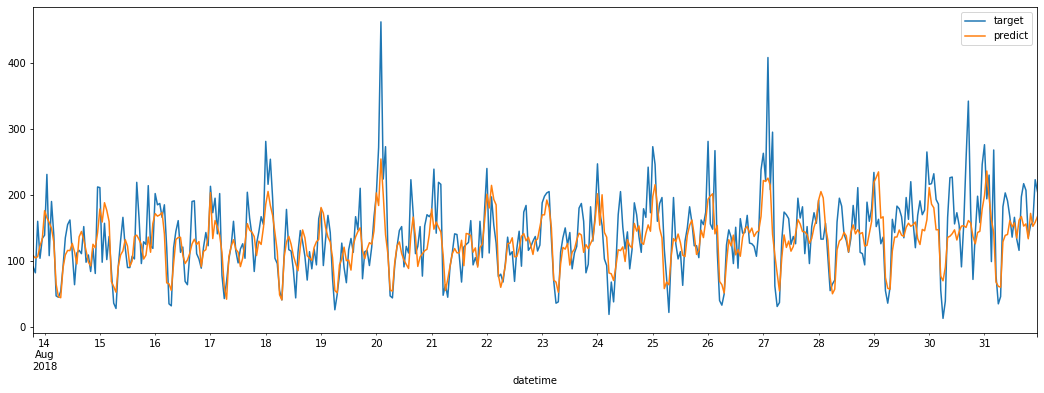

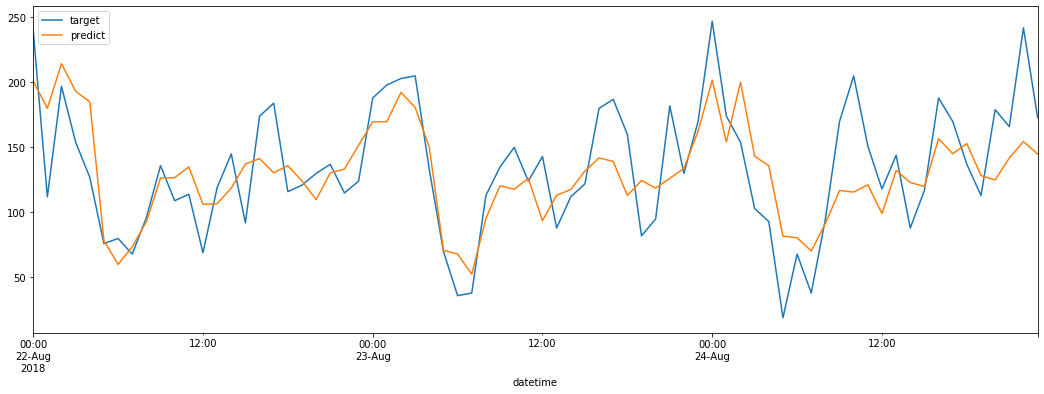

In [418]:
graphicaizer(forest_model_predictions)

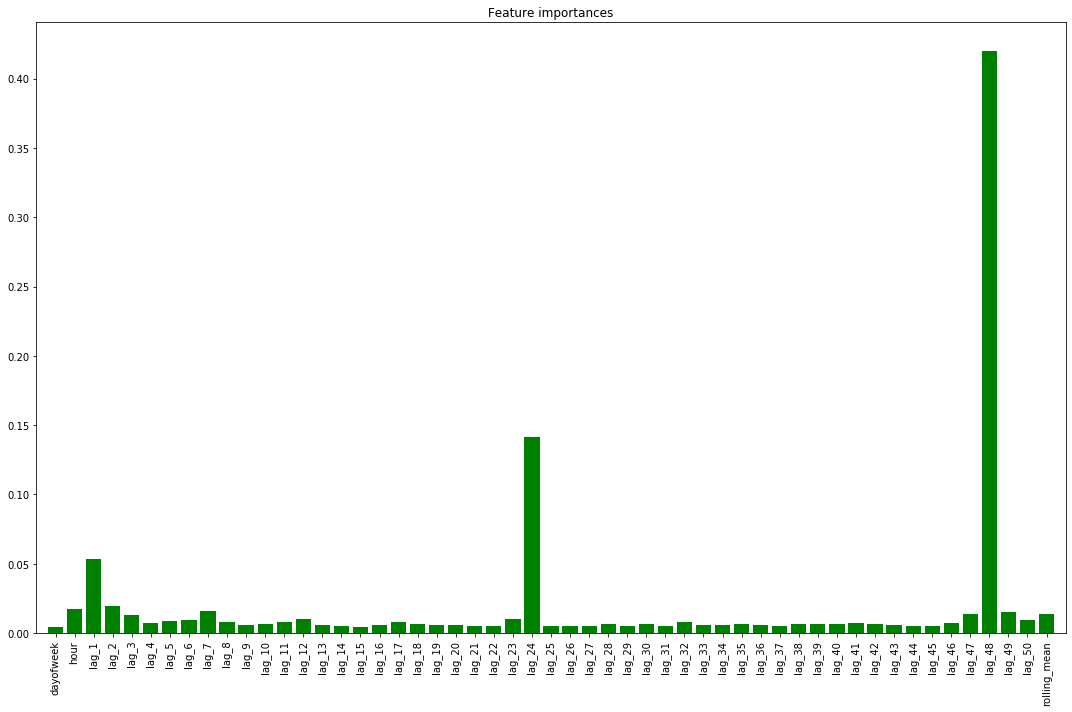

In [390]:
#Строю график важности признаков модели
feature_importance_hist(forest_model, features_train)

In [392]:
%%time
#Обучаю модель на оптимальных гиперпараметрах
lg_model = lgb.LGBMRegressor(max_depth= lg_params['max_depth'],
                             learning_rate = lg_params['learning_rate'],
                             num_leaves = lg_params['num_leaves'],
                             n_estimators = lg_params['n_estimators'])

lg_model.fit(features_train, target_train)
lg_model_predictions = lg_model.predict(features_test)

#Определяю метрику RMSE
lg_RMSE = round(RMSE(target_test, lg_model_predictions), 3)
print('RMSE модели LGBMRegressor:', lg_RMSE)

RMSE модели LGBMRegressor: 39.63
CPU times: user 26.4 s, sys: 142 ms, total: 26.5 s
Wall time: 27.1 s


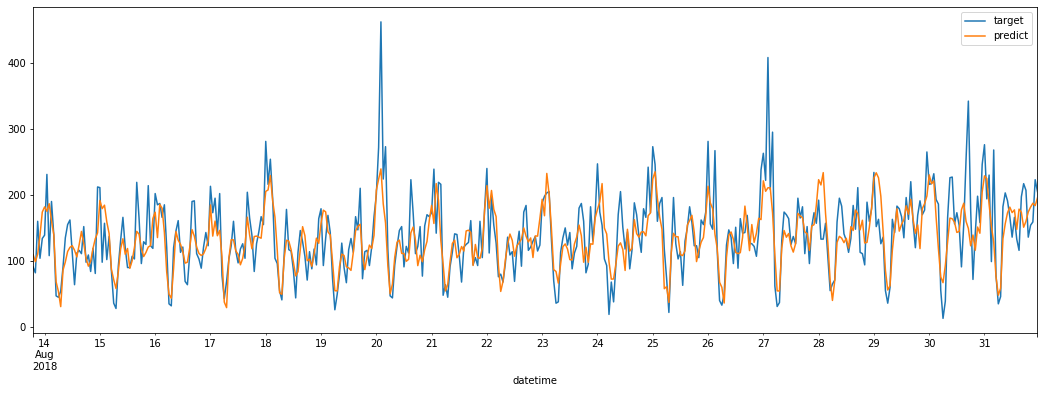

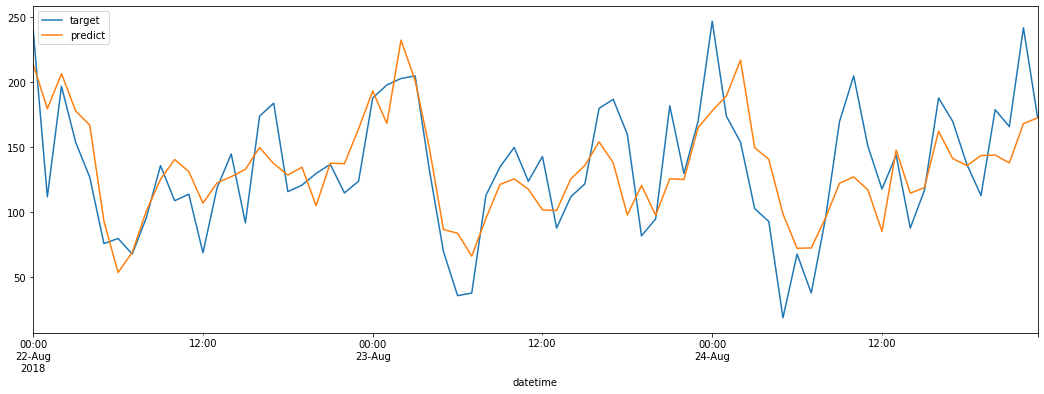

In [419]:
graphicaizer(lg_model_predictions)

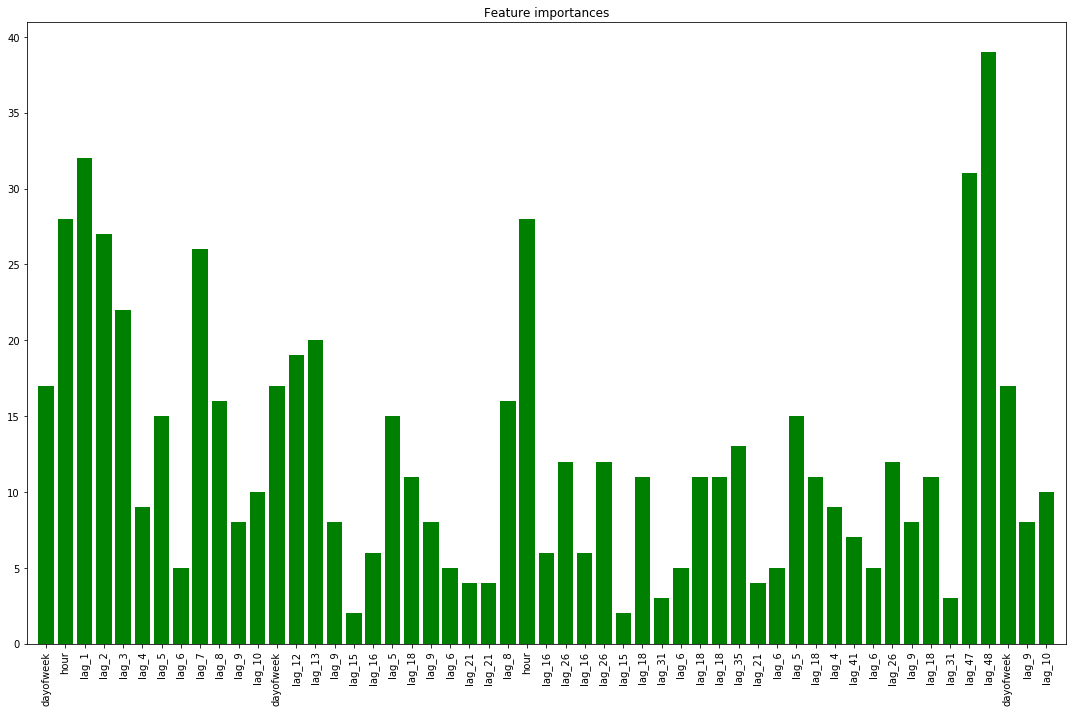

In [394]:
#Строю график важности признаков модели
feature_importance_hist(lg_model, features_train)

In [395]:
%%time
import catboost as cb #Импортирую CatBoost (почему-то без повторного импортирования ячейка не работала)
#Обучаю модель на оптимальных гиперпараметрах

#cb_model = cb.CatBoostRegressor(iterations=cb_params['iterations'],
#                                learning_rate=cb_params['learning_rate'],
#                                depth=cb_params['depth'])


cb_model = cb.CatBoostRegressor(learning_rate=cb_params['learning_rate'],
                                depth=cb_params['depth'])

cb_model.fit(features_train, target_train, verbose=10)
cb_model_predictions = cb_model.predict(features_test)

#Определяю метрику RMSE
cb_RMSE = round(RMSE(target_test, cb_model_predictions), 3)
print('RMSE модели CatBoostRegressor:', cb_RMSE)

0:	learn: 38.1194355	total: 8.93ms	remaining: 8.92s
10:	learn: 33.3766940	total: 599ms	remaining: 53.8s
20:	learn: 30.0466457	total: 1.28s	remaining: 59.8s
30:	learn: 27.7692394	total: 1.79s	remaining: 55.9s
40:	learn: 26.1857816	total: 2.28s	remaining: 53.4s
50:	learn: 25.0380100	total: 2.87s	remaining: 53.5s
60:	learn: 24.2065113	total: 3.46s	remaining: 53.3s
70:	learn: 23.5774875	total: 4.06s	remaining: 53.1s
80:	learn: 23.1009923	total: 4.56s	remaining: 51.7s
90:	learn: 22.7255201	total: 5.06s	remaining: 50.6s
100:	learn: 22.4873977	total: 5.65s	remaining: 50.3s
110:	learn: 22.2760365	total: 6.24s	remaining: 50s
120:	learn: 22.0941260	total: 6.74s	remaining: 49s
130:	learn: 21.8455061	total: 7.24s	remaining: 48s
140:	learn: 21.6919077	total: 7.82s	remaining: 47.7s
150:	learn: 21.5293466	total: 8.32s	remaining: 46.8s
160:	learn: 21.4113334	total: 8.91s	remaining: 46.5s
170:	learn: 21.2576676	total: 9.51s	remaining: 46.1s
180:	learn: 21.1716493	total: 10s	remaining: 45.2s
190:	learn:

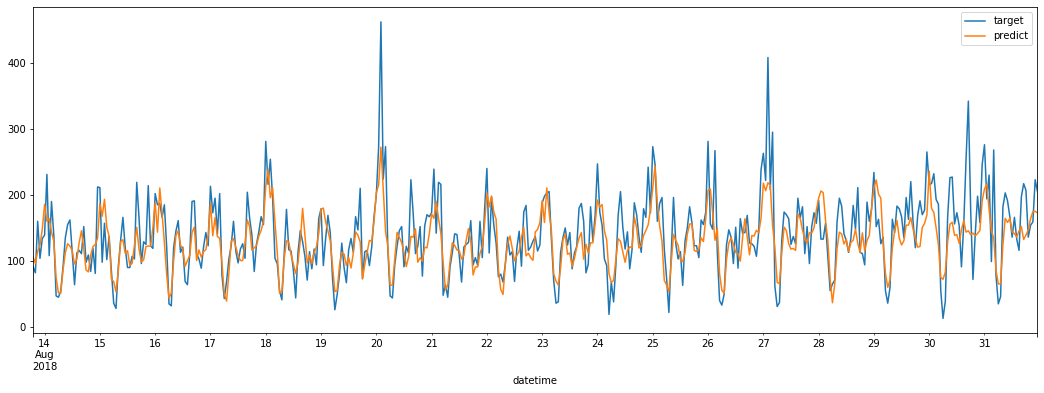

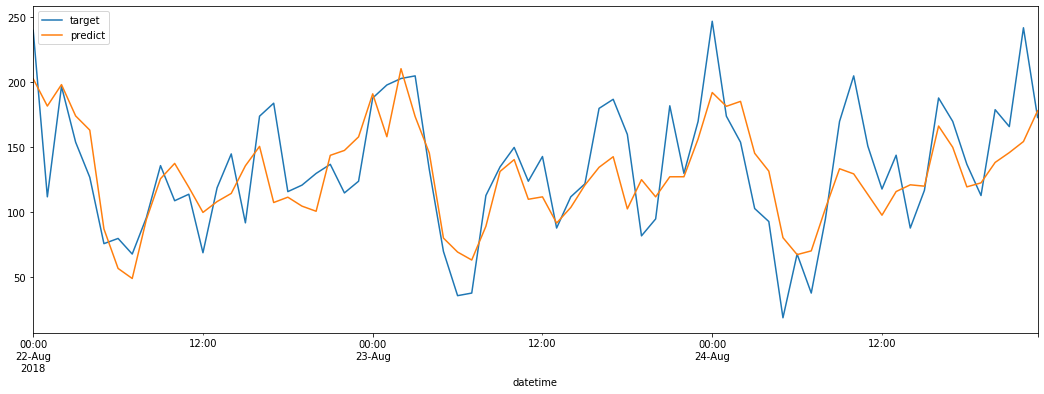

In [420]:
graphicaizer(cb_model_predictions)

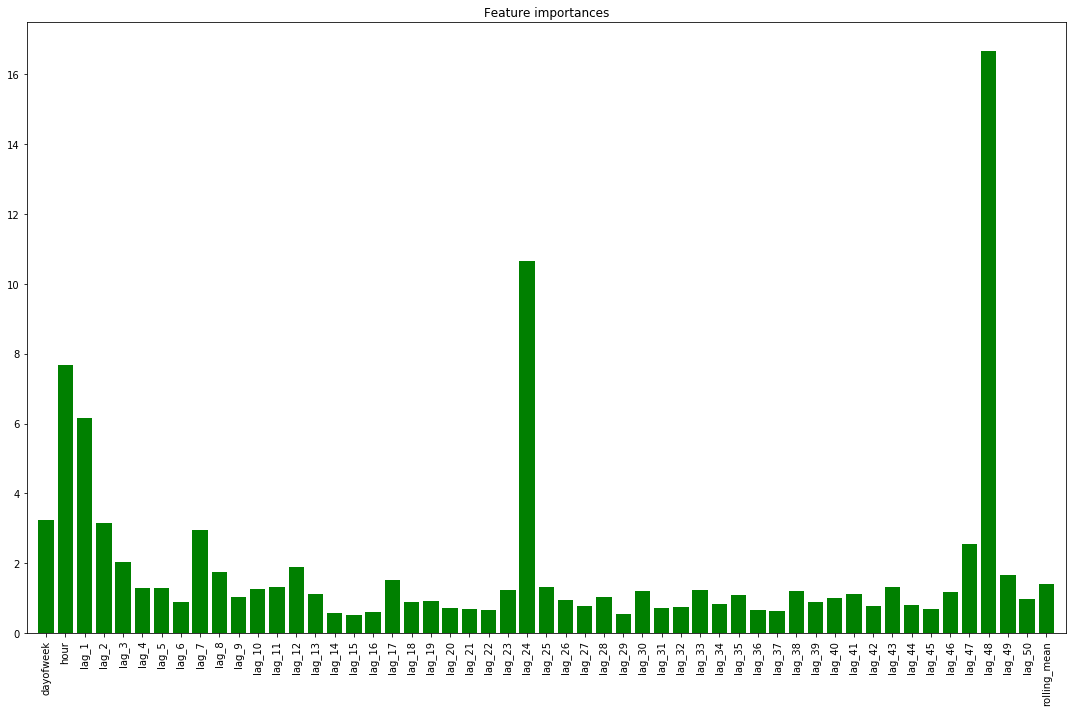

In [397]:
#Строю график важности признаков модели
feature_importance_hist(cb_model, features_train)

Наилучшей метрики RMSE удалось достичь при работе модели Линейной регрессии🤷🏻‍♂️. Проверм ее на адекватность.

In [398]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))

RMSE для проверки модели на адекватность: 59.019


# 5. Общий вывод<a id='step8'></a>

При выполнении проекта проделана следующая работа.
<br>На первом этапе произведена загрузка данных и их подготовка для обучения моделей.

<br>**Исходный датасет состоял из следующих столбцов:**
<br>• datetime — дата и время заказа такси
<br>• num_orders — количество заказов такси (целевой признак)
<br>Количество строк в датасете 4416. Пропуски в данных отсутствовали.

<br>Для подготовки данных к функции *pd.read_csv* были применены парамтры *index_col* и *parse_dates* для определения данных типа datetime и назначением этого столбца в качестве индексов. Дополнительно выполнено ресемплирование на промежуток времени 1 час.

На втором этапе проведен анализ данных. Методом декомпозиции были выделены следующие аспекты:
1. За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. Но данную гипотезу можно подтвердить или опровергнуть только имея данные за несколько лет.
2. На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

На третьем этапе к датасету были добавлены дополнительные признаки, а именно день недели, час "отстающие значения" и скользящее среднее. На дополнном датасете подобраны оптимальные гиперпараметры для моделей.

На четвертом этапе проведено тестирование всех моделей, каждой из них удалось достичь требуемого показателя метрики RMSE. Анализ сравнительных графиков в двух масштабах, показал, что модели хуже всего справляются с предсказаниями на высоких пиках и на провалах, но в целом, угадывают направления движения. Наилучший показатель в данном случае у LGBMRegressor, он равен 39.63.

Дополнительно хочу отметить, что неплохо было бы провести анализ вызовов такси в аэропорты, имея при этом еще и данные по прибывающим/улетающим рейсам.